# Project 1

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
from helpers import *
from implementations import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

np.random.seed(0)

## File names

In [2]:
train_data_file = 'train.csv'
test_data_file  = 'test.csv'
submission_file = 'submission.csv'

## Loading the data

In [3]:
y, tx, ids = load_csv_data(train_data_file, sub_sample=False)

## Exploring the data

In [4]:
sample_shape = tx.shape
print("{N} samples of {D} features.".format(N=sample_shape[0], D=sample_shape[1]))

250000 samples of 30 features.


In [5]:
print("labels = " + str(y))

labels = [ 1. -1. -1. ...  1. -1. -1.]


For labels, 1 corresponds to a ___signal___ event (Higgs boson decay signature) and -1 corresponds to a ___background___ event (other decay signature)

In [6]:
headers = "DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt"
headers = headers.split(",")
headers = {k:h for k, h in enumerate(headers)}
print("data features:")
headers

data features:


{0: 'DER_mass_MMC',
 1: 'DER_mass_transverse_met_lep',
 2: 'DER_mass_vis',
 3: 'DER_pt_h',
 4: 'DER_deltaeta_jet_jet',
 5: 'DER_mass_jet_jet',
 6: 'DER_prodeta_jet_jet',
 7: 'DER_deltar_tau_lep',
 8: 'DER_pt_tot',
 9: 'DER_sum_pt',
 10: 'DER_pt_ratio_lep_tau',
 11: 'DER_met_phi_centrality',
 12: 'DER_lep_eta_centrality',
 13: 'PRI_tau_pt',
 14: 'PRI_tau_eta',
 15: 'PRI_tau_phi',
 16: 'PRI_lep_pt',
 17: 'PRI_lep_eta',
 18: 'PRI_lep_phi',
 19: 'PRI_met',
 20: 'PRI_met_phi',
 21: 'PRI_met_sumet',
 22: 'PRI_jet_num',
 23: 'PRI_jet_leading_pt',
 24: 'PRI_jet_leading_eta',
 25: 'PRI_jet_leading_phi',
 26: 'PRI_jet_subleading_pt',
 27: 'PRI_jet_subleading_eta',
 28: 'PRI_jet_subleading_phi',
 29: 'PRI_jet_all_pt'}

 - all variables are floating point, except PRI_jet_num which is integer
 - variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
 - variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
 - it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.


## Pre-processing data
- split column "mn ’PRI jet num'
- replace -999 with average of whole train
- split data 0.8:0.2
- normalize
- add bias in data

In [7]:
def preprocess(x):
    N = x.shape[0]
    
    # replacing -999 values with feature mean
    pos = np.where(x == -999)
    x[pos] = np.nan
    c_mean = np.nanmean(x, axis=0)
    x[pos] = c_mean[pos[1]]
    
    # split column PRI_jet_num
    jet_num = np.zeros((N, 4))
    for i in range(4):
        row = np.where(x[:, 23] == i)[0]
        jet_num[row, i] = 1
    x = np.c_[x[:, :23], x[:, 24:]]
    x = np.c_[x, jet_num]
    
    # Normalize
    # [:,:-4] don't normalize the discrete values
    mean_x = np.mean(x[:,:-4], axis=0)
    std_x = np.std(x[:,:-4], axis=0)
    x[:,:-4] = (x[:,:-4] - mean_x) / std_x
    
    # adding bias term
    x = np.c_[np.ones(N), x]
    
    return x
    

In [8]:
data = preprocess(tx)

# splitting data 80% - 20%
num_samples = data.shape[0]

fraction_train = 0.8
rinds = np.random.permutation(num_samples)

data_train = data[rinds[:int(num_samples * fraction_train)]] 
y_train = y[rinds[:int(num_samples * fraction_train)]]  

data_test = data[rinds[int(num_samples * fraction_train):]] 
y_test = y[rinds[int(num_samples * fraction_train):]]  

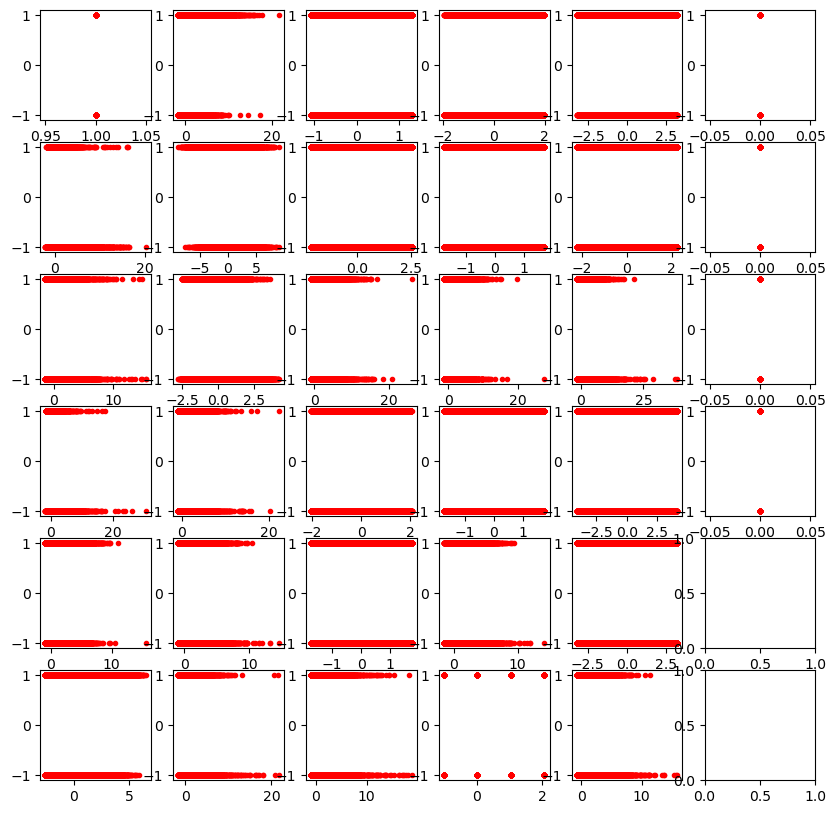

In [9]:
# check feature-label relations after data pre-processing
fig, axs = plt.subplots(6, 6, figsize=(10, 10))
for i, x_i in enumerate(data_train.T):
    axs[i % 6, i // 6].plot(x_i, y_train, 'r.')

## Helpers

In [10]:
def accuracy(labels_gt, labels_pred):
    """ Computes accuracy.
    
    Args:
        labels_gt (np.array): GT labels of shape (N, ).
        labels_pred (np.array): Predicted labels of shape (N, ).
        
    Returns:
        float: Accuracy, in range [0, 1].
    """
    return np.sum(labels_gt == labels_pred) / labels_gt.shape[0]

In [11]:
def test_phase(w, pred=[], y=y_test, x=data_test, score=True):
    if len(pred) == 0:
        pred = x @ w
        pred = np.array([(-1. if l <= 0 else 1.) for l in pred])
    if score:
        #loss
        test_loss = mse_loss(y, x, w)
        print("test loss: " + str(test_loss))
        # accuracy
        acc = accuracy(y, pred)
        print("Accuracy = " + str(acc))
    return pred

## Linear regression using gradient descent

In [12]:
# training phase for linear regression with GD
D = data_train.shape[1]
initial_w = np.ones(D)
max_iters = 500
gamma = 0.2

mse_gd_w, mse_gd_training_loss = mean_squared_error_gd(y_train, data_train, initial_w, max_iters, gamma)

GD: W = [-3.12581302e-01  6.42827901e-03 -2.55247554e-01 -2.56835906e-01
 -6.67831861e-03  2.30341405e-02  8.76138937e-02  3.62343791e-03
  2.80323062e-01 -2.58356246e-02 -1.13496757e-01 -1.89925552e-01
  1.22112579e-01  7.53627587e-02  2.05594033e-01  8.68322588e-04
 -1.32162292e-04  3.12188531e-01 -1.37536032e-03  4.13321218e-03
  1.04152497e-01  1.34350866e-03 -5.13788808e-02  1.01568705e-01
  2.20459950e-03  1.29229540e-03 -1.95342797e-02  2.51195280e-03
 -2.50150094e-03  2.20176740e-02  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00],
 training loss = 0.340912566472905



In [13]:
# testing phase for linear regresison with GD
pred = test_phase(mse_gd_w)

test_y, test_tx, test_ids = load_csv_data(test_data_file, sub_sample=False)
test_data = preprocess(test_tx)
test_pred = test_phase(mse_gd_w, x=test_data, score=False)
create_csv_submission(test_ids, test_pred, "mse_gd_submission.csv")

test loss: 0.3389375941211703
Accuracy = 0.74534


## Linear regression using stochastic gradient descent

In [14]:
# training phase for linear regression with SGD
D = data_train.shape[1]
initial_w = np.ones(D)
max_iters = 100
gamma = 0.1

mse_sgd_w, mse_sgd_training_loss = mean_squared_error_sgd(y_train, data_train, initial_w, max_iters, gamma)

SGD: W = [0.92760732 1.01058725 0.99176593 1.00897179 1.00895812 1.
 1.         1.         0.96098849 1.04616986 1.0203335  1.01393531
 0.90651741 1.         1.01844511 1.00811099 1.0213911  1.01508626
 1.0400308  0.88210407 1.01425914 1.06962283 1.02550365 0.99845768
 1.07333645 0.94417993 1.         1.         1.         1.01638888
 1.         1.         1.         1.        ],
 training loss = 37.9818382969221



In [15]:
# testing phase for linear regresison with SGD
pred = test_phase(mse_sgd_w)

# the accuracy ranges from 0.5ish to 0.75ish when the random seed is not set
# here the seed is set to 0 for reproducibility

test_pred = test_phase(mse_sgd_w, x=test_data, score=False)
create_csv_submission(test_ids, test_pred, "mse_sgd_submission.csv")

test loss: 38.14951916515017
Accuracy = 0.56966


## Least squares regression using normal equations

In [16]:
# training phase for LS regression
ls_w, ls_loss = least_squares(y_train, data_train)

LS: W = [-3.12581147e-01  6.40195429e-03 -2.55282164e-01 -2.56777390e-01
 -6.89612655e-03  2.30449642e-02  8.75859904e-02  3.61179216e-03
  2.80271551e-01 -2.58272120e-02 -4.98294592e+01 -1.89896279e-01
  1.22162157e-01  7.53611230e-02  9.83551693e+00  8.68064831e-04
 -1.32480450e-04  9.79292354e+00 -1.37483495e-03  4.13342034e-03
  1.04207259e-01  1.34324400e-03 -5.14380862e-02  1.01398205e-01
  2.20410824e-03  1.29214385e-03 -1.96293626e-02  2.51203016e-03
 -2.50243047e-03  4.21371788e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00],
 training loss = 0.34091253374220704



In [17]:
# testing phase for LS regression
pred = test_phase(ls_w)

test_pred = test_phase(ls_w, x=test_data, score=False)
create_csv_submission(test_ids, test_pred, "ls_submission.csv")

test loss: 0.33893695190260553
Accuracy = 0.74534


## Ridge regression using normal equations

In [18]:
# training phase for ridge regression
lambda_ = 0.3
rr_w, rr_loss = ridge_regression(y_train, data_train, lambda_)

RR: W = [-0.19540207 -0.00211756 -0.1483152  -0.02526952  0.04158801  0.04072969
  0.04093489 -0.02553658  0.07068217 -0.02572161  0.02419225 -0.06607556
  0.09183806  0.0526292   0.08822831  0.00019997 -0.00170624  0.0266495
 -0.00027961  0.00267495  0.00156554  0.00220717  0.0042734   0.01383086
  0.00091979  0.00113319 -0.02731224  0.00138436 -0.0016896   0.00238526
  0.          0.          0.          0.        ],
 training loss = 0.3665966554487001



In [19]:
# testing phase for ridge regression
pred = test_phase(rr_w)

test_pred = test_phase(rr_w, x=test_data, score=False)
create_csv_submission(test_ids, test_pred, "rr_submission.csv")

test loss: 0.3655179085626631
Accuracy = 0.728


## Logistic Regression

In [20]:
# switch labels to y \in {0, 1} for logistic regression
y_train_log = y_train.copy()
y_train_log[y_train_log < 0] = 0
y_test_log = y_test.copy()
y_test_log[y_test_log < 0] = 0

In [21]:
# training logistic regression
initial_w = np.ones(data_train.shape[1])
max_iters = 200
gamma = 0.1

lr_w, lr_loss = logistic_regression(y_train_log, data_train, initial_w, max_iters, gamma)

LogReg: W = [-7.49443522e-01 -2.07927437e-01 -4.72472204e-01 -3.70922783e-01
  3.18038716e-01  5.87663867e-01  6.24764892e-01  8.97540358e-01
  8.10700853e-01 -1.05028557e-01 -1.18309382e-01  9.52054989e-04
  4.61473306e-01  3.99290488e-01  8.88353867e-01 -5.99111025e-03
  2.31360077e-01  6.80968360e-02 -1.76763246e-02  2.79653284e-01
  1.08008388e-01  1.68025291e-01 -1.44163633e-01  1.45394758e-01
  7.91288987e-02  2.98259400e-01  3.69754831e-02  1.78218118e-01
  2.18767682e-01 -8.48331756e-02  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00],
 training loss = 0.5526604988440078



In [22]:
# testing logistic regression
test_predict = logistic_regression_classify(data_test, lr_w)
test_predict[test_predict == 0] = -1
print("accuracy :",accuracy(y_test,test_predict))
print("test loss:", loss_logistic(data_test,y_test_log,lr_w,0)) 

# create_csv_submission(test_ids, test_pred, "lr_submission.csv")

accuracy : 0.72522
test loss: 0.5486892623102603


## Regularized Logistic Regression

In [23]:
# training regularized logistic regression
initial_w = np.ones(data_train.shape[1])
max_iters = 100
gamma = 0.1
lambda_ = 1e-1

rlr_w, rlr_loss = reg_logistic_regression(y_train_log, data_train, lambda_, initial_w, max_iters, gamma)

In [25]:
test_predict = logistic_regression_classify(data_test, rlr_w)
test_predict[test_predict == 0] = -1
print("accuracy :",accuracy(y_test,test_predict))
print("test loss:", loss_logistic(data_test,y_test_log,lr_w,0))
# create_csv_submission(test_ids, test_pred, "rlr_submission.csv")

accuracy : 0.72546
test loss: 0.5486892623102603


## Logistic Regression with imbalance weights

In [26]:
im = imbal(y_train_log)
# training logistic regression
initial_w = np.ones(data_train.shape[1])
max_iters = 200
gamma = 0.1

ilr_w, ilr_loss = logistic_regression(y_train_log, data_train, initial_w, max_iters, gamma,im)

LogReg: W = [-1.53872723 -0.16673357 -0.55882259 -0.40011914  0.32699213  0.48790745
  0.54689889  0.69127738  0.75645363 -0.12791112 -0.14699944 -0.02567524
  0.37577525  0.30474303  0.77316139 -0.00363168  0.10983573  0.16538925
 -0.01940514  0.13661624  0.10187202  0.069491   -0.1575891   0.15021521
  0.03398953  0.14070641 -0.03068071  0.05049975  0.07750829 -0.1142638
  1.          1.          1.          1.        ],
 training loss = 0.7049436197877881



In [27]:
# testing logistic regression
test_predict = logistic_regression_classify(data_test, ilr_w)
test_predict[test_predict == 0] = -1
print("accuracy :",accuracy(y_test,test_predict))
print("test loss:", loss_logistic(data_test,y_test_log,ilr_w,0,imbal(y_test_log)))

# create_csv_submission(test_ids, test_pred, "lr_submission.csv")

accuracy : 0.71698
test loss: 0.6981889346050788


## Reg Logistic Regression with imbalance weights

In [28]:
# training regularized logistic regression
initial_w = np.ones(data_train.shape[1])
max_iters = 100
gamma = 0.1
lambda_ = 1e-1

irlr_w, irlr_loss = reg_logistic_regression(y_train_log, data_train, lambda_, initial_w, max_iters, gamma,imbal(y_train_log))

In [29]:
test_predict = logistic_regression_classify(data_test, irlr_w)
test_predict[test_predict == 0] = -1
print("accuracy :",accuracy(y_test,test_predict))
print("test loss:", loss_logistic(data_test,y_test_log,irlr_w,0, imbal(y_test_log)))
# create_csv_submission(test_ids, test_pred, "rlr_submission.csv")

accuracy : 0.71576
test loss: 0.7645848539853911
